## Overview
- References: [[Mnih et. al, 2008]](https://www.cs.toronto.edu/~vmnih/docs/ebstop.pdf), [[Bardenet et. al, 2014]](https://proceedings.mlr.press/v32/bardenet14.html), and [[Wilson, 2024]](http://arxiv.org/abs/2402.16811).
- This notebook surveys the `level_tests`  methods provided by `trieste_sampling`.
- Given a random variable $X: \Omega \to [a, b]$, these functions generate estimates $\overline{X}_n$ that are on the same side of $\lambda \in [a, b]$ as $\mathbb{E}[X]$ with probabilitie at least $1 - \delta$, i.e.
  \begin{align} 
  \mathbb{P}\left[\mathbb{1}_{\overline{X}_n \le \lambda} = \mathbb{1}_{\mathbb{E}[X] \le \lambda}\right] \ge 1 - \delta.
  \end{align}
- In the code, $\lambda$ is referred to as the `level` and $\delta$ is referred to as the `risk_tolerance`.
- Below, we show how this method behaves when used to infer whether expected values of Bernoulli random variables exceed $\lambda = 10^{-5}$.

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from trieste_stopping.utils.level_tests import ClopperPearsonLevelTest
from trieste_stopping.utils.schedules import GeometricSchedule
from tqdm import tqdm

In [2]:
# A level test using Clopper-Pearson intervals where sample sizes start at four and increase by 50% at each round
test = ClopperPearsonLevelTest(size_schedule=GeometricSchedule(1.5, initial_value=4))

# Run the test multiple time to see how it behaves
level = 1e-5
num_runs = 10
num_risks = 5
num_probs = 5
log_risks = np.linspace(-4, 0, num_risks)  # chance of encountering an incorrect result
log_probs = np.linspace(-4, 0, num_probs)  # Parameters for Benoulli random variables
sample_sizes = np.zeros([num_risks, num_probs, num_runs], dtype=np.float64)
for r in tqdm(range(num_runs)):
    for i, risk in enumerate(np.power(10, log_risks)):
        for j, prob in enumerate(np.power(10, log_probs)):
            gen = lambda n: tf.cast(tf.random.uniform([n], dtype=prob.dtype) < prob, prob.dtype)
            result = test(gen, level=level, risk=risk, axis=-1)
            sample_sizes[i, j, r] = result.sample_size

/Users/jtwilson/projects/trieste_stopping/trieste_stopping/utils/level_tests.py:73: UserWarning: No limits were set for the amount of time or number of samples that tests may use. This may result in excessively long runtimes.
  warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:21<00:00, 32.19s/it]


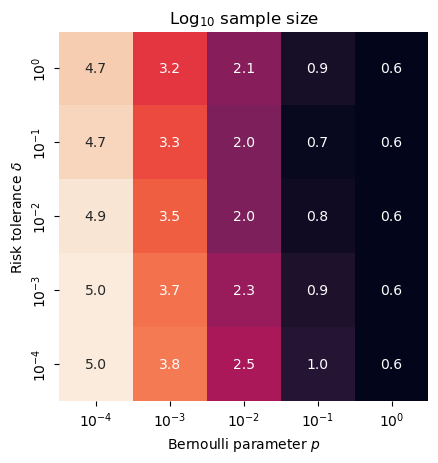

In [3]:
ax = sns.heatmap(
    np.flipud(np.log10(np.median(sample_sizes, axis=-1))),
    cbar=False,
    cmap="rocket",
    fmt=".1f", 
    annot=True,
)
ax.set_title("Log$_{10}$ sample size")
ax.set_xlabel("Bernoulli parameter $p$")
ax.set_xticklabels([f"$10^{{{int(lp)}}}$" for lp in log_probs])
ax.set_ylabel("Risk tolerance $\delta$")
ax.set_yticklabels([f"$10^{{{int(lr)}}}$" for lr in np.flipud(log_risks)])
ax.set_aspect("equal")